# Desenvolvimento de Modelo (Gestock):

Pré-requisito: 
- Python 3.13.5
- Biblioteca KaggleAPI baixada para utilizar os datasets.
- Chave de API própria adquirida com ```Kaggle.json```

---
**Etapas para Download:**

1. Criar conta no Kaggle (caso não tenha);
2. Acessar seu User Profile, ir em Settings e procurar "Legacy API Credentials". Isso irá baixar "Kaggle.json";
3. Mover este arquivo JSON para ```C:\Users\<Windows-username>\.kaggle\``` (caso a pasta .kaggle não exista, basta criá-la);
4. Baixar biblioteca Kaggle. ```pip install kaggle```.
---

Rodar os scripts a seguir vai baixar todo o dataset do M5 Forecasting.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler
import os
import zipfile
from kaggle.api.kaggle_api_extended import KaggleApi

In [4]:
DATA_DIR = r"../Data"
COMPETITION = "m5-forecasting-accuracy"

os.makedirs(DATA_DIR, exist_ok=True)

api = KaggleApi()
api.authenticate()

api.competition_download_files(
    COMPETITION,
    path=DATA_DIR,
    quiet=False
    )

zip_path = os.path.join(DATA_DIR, f"{COMPETITION}.zip")

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(DATA_DIR)

os.remove(zip_path)

100%|██████████| 45.8M/45.8M [00:02<00:00, 21.7MB/s]


In [3]:
calendarioSazonal = pd.read_csv(r'../Data/calendar.csv').drop(columns=['snap_TX', 'snap_WI', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'weekday'])
calendarioSazonal = calendarioSazonal[:1913] #  Limitando o calendário ao mesmo número de dias que o dataset de vendas
calendarioSazonal

,date,wm_yr_wk,wday,month,year,d,snap_CA
0,2011-01-29,11101,1,1,2011,d_1,0
1,2011-01-30,11101,2,1,2011,d_2,0
2,2011-01-31,11101,3,1,2011,d_3,0
3,2011-02-01,11101,4,2,2011,d_4,1
4,2011-02-02,11101,5,2,2011,d_5,1
...,...,...,...,...,...,...,...
1908,2016-04-20,11612,5,4,2016,d_1909,0
1909,2016-04-21,11612,6,4,2016,d_1910,0
1910,2016-04-22,11612,7,4,2016,d_1911,0
1911,2016-04-23,11613,1,4,2016,d_1912,0


In [ ]:
vendasTrain = pd.read_csv(r'../Data/sales_train_validation.csv')
vendasTrain #  Cada linha consiste em um produto em uma loja. São 3049 produtos em 10 lojas diferentes para 1941 dias.

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,2,0,0,0,0,0,1,0,0,1
30486,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
30487,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,2,1,0,2,0,1,0,0,1,0
30488,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,1,0,0,1,0,3,1,3


In [ ]:
sellPrices = pd.read_csv(r'../Data/sell_prices.csv')
sellPrices

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.00
6841117,WI_3,FOODS_3_827,11618,1.00
6841118,WI_3,FOODS_3_827,11619,1.00
6841119,WI_3,FOODS_3_827,11620,1.00


In [27]:
print(calendarioSazonal.isna().sum())
calendarioSazonal.info()

date        0
wm_yr_wk    0
wday        0
month       0
year        0
d           0
snap_CA     0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1913 entries, 0 to 1912
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      1913 non-null   object
 1   wm_yr_wk  1913 non-null   int64 
 2   wday      1913 non-null   int64 
 3   month     1913 non-null   int64 
 4   year      1913 non-null   int64 
 5   d         1913 non-null   object
 6   snap_CA   1913 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 104.7+ KB


In [28]:
print(vendasTrain.isna().sum())
vendasTrain.info()

id          0
item_id     0
dept_id     0
cat_id      0
store_id    0
           ..
d_1909      0
d_1910      0
d_1911      0
d_1912      0
d_1913      0
Length: 1919, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: int64(1913), object(6)
memory usage: 446.4+ MB


In [29]:
print(sellPrices.isna().sum())
sellPrices.info()

store_id      0
item_id       0
wm_yr_wk      0
sell_price    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int64  
 3   sell_price  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB


In [30]:
wideSales = vendasTrain.melt(id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
                          var_name='day')

In [31]:
wideSales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58327370 entries, 0 to 58327369
Data columns (total 8 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   id        object
 1   item_id   object
 2   dept_id   object
 3   cat_id    object
 4   store_id  object
 5   state_id  object
 6   day       object
 7   value     int64 
dtypes: int64(1), object(7)
memory usage: 3.5+ GB


In [32]:
wideSalesCalendar = wideSales.merge(
    calendarioSazonal,
    left_on='day',
    right_on='d',
    how='left'
).drop(columns='d')

In [33]:
demandComplete = wideSalesCalendar.merge(sellPrices,left_on=['item_id','store_id','wm_yr_wk'], right_on=['item_id','store_id','wm_yr_wk'], how='left')

In [34]:
demandComplete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58327370 entries, 0 to 58327369
Data columns (total 15 columns):
 #   Column      Dtype  
---  ------      -----  
 0   id          object 
 1   item_id     object 
 2   dept_id     object 
 3   cat_id      object 
 4   store_id    object 
 5   state_id    object 
 6   day         object 
 7   value       int64  
 8   date        object 
 9   wm_yr_wk    int64  
 10  wday        int64  
 11  month       int64  
 12  year        int64  
 13  snap_CA     int64  
 14  sell_price  float64
dtypes: float64(1), int64(6), object(8)
memory usage: 6.5+ GB


In [35]:
movimentacaoLojaCA_1 = demandComplete[demandComplete['store_id']=='CA_1'].copy()
movimentacaoLojaCA_1.isna().sum()

id                  0
item_id             0
dept_id             0
cat_id              0
store_id            0
state_id            0
day                 0
value               0
date                0
wm_yr_wk            0
wday                0
month               0
year                0
snap_CA             0
sell_price    1129842
dtype: int64

In [106]:
movimentacaoLojaCA_1.isna().sum()

id                  0
item_id             0
dept_id             0
cat_id              0
store_id            0
state_id            0
day                 0
value               0
date                0
wm_yr_wk            0
wday                0
month               0
year                0
snap_CA             0
sell_price    1129842
dtype: int64

In [107]:
movimentacaoLojaCA_1.shape

(5832737, 15)

In [108]:
movimentacaoLojaCA_1

,id,item_id,dept_id,cat_id,store_id,state_id,day,value,date,wm_yr_wk,wday,month,year,snap_CA,sell_price
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,1,1,2011,0,NaN
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,1,1,2011,0,NaN
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,1,1,2011,0,NaN
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,1,1,2011,0,NaN
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,1,1,2011,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58299924,FOODS_3_823_CA_1_validation,FOODS_3_823,FOODS_3,FOODS,CA_1,CA,d_1913,1,2016-04-24,11613,2,4,2016,0,2.98
58299925,FOODS_3_824_CA_1_validation,FOODS_3_824,FOODS_3,FOODS,CA_1,CA,d_1913,0,2016-04-24,11613,2,4,2016,0,2.48
58299926,FOODS_3_825_CA_1_validation,FOODS_3_825,FOODS_3,FOODS,CA_1,CA,d_1913,2,2016-04-24,11613,2,4,2016,0,3.98
58299927,FOODS_3_826_CA_1_validation,FOODS_3_826,FOODS_3,FOODS,CA_1,CA,d_1913,0,2016-04-24,11613,2,4,2016,0,1.28


In [36]:
movimentacaoLojaCA_1['sell_price'] = (
    movimentacaoLojaCA_1
    .sort_values('day')
    .groupby('item_id')['sell_price']
    .bfill()
    .ffill()
)


In [110]:
movimentacaoLojaCA_1.isna().sum()

id            0
item_id       0
dept_id       0
cat_id        0
store_id      0
state_id      0
day           0
value         0
date          0
wm_yr_wk      0
wday          0
month         0
year          0
snap_CA       0
sell_price    0
dtype: int64

In [37]:
LAGS = [1, 2, 3]

for lag in LAGS:
    movimentacaoLojaCA_1[f'lag_{lag}'] = (
        movimentacaoLojaCA_1
        .groupby(['item_id'])['value']
        .shift(lag)
    )

WINDOWS = [7, 14]

for w in WINDOWS:
    movimentacaoLojaCA_1[f'rolling_mean_{w}'] = (
        movimentacaoLojaCA_1
        .groupby(['item_id'])['value']
        .transform(lambda x: x.shift(1).rolling(w, min_periods=1).mean())
    )


In [38]:
for w in WINDOWS:
    movimentacaoLojaCA_1[f'rolling_std_{w}'] = (
        movimentacaoLojaCA_1
        .groupby(['item_id'])['value']
        .transform(lambda x: x.shift(1).rolling(w, min_periods=1).std())
    )


In [39]:
movimentacaoLojaCA_1['day'] = movimentacaoLojaCA_1['day'].str.replace('d_', '').astype(int)

In [40]:
feature_cols = [
    'value',
    'sell_price',
    'wday', 'day', 'month', 'year',
    'lag_1', 'lag_2', 'lag_3',
    'rolling_mean_7', 'rolling_mean_14',
    'rolling_std_7', 'rolling_std_14'
]

movimentacaoLojaCA_1 = movimentacaoLojaCA_1.dropna(subset=['lag_3'])

In [76]:
results = []
for item_id, group in movimentacaoLojaCA_1.groupby('item_id'):
    X = group.copy()[feature_cols]

    scaler = RobustScaler() #  Normalizar dados para reduzir impacto de outliers
    X_scaled = scaler.fit_transform(X)
    model = IsolationForest(n_estimators=300, contamination=0.005, random_state=42, n_jobs=-1)
    model.fit(X_scaled)

    group['anomaly_score'] = model.decision_function(X_scaled)
    group['anomaly'] = model.predict(X_scaled)
    results.append(group)



In [ ]:
pd.concat(results).to_csv('../Data/movimentacaoLojaCA_1_anomalies.csv')

In [ ]:
movimentacaoLojaCA_1 = pd.read_csv('../Data/movimentacaoLojaCA_1_anomalies.csv').drop(columns='Unnamed: 0')
movimentacaoLojaCA_1['date'] = pd.to_datetime(movimentacaoLojaCA_1['date'])

In [70]:
movimentacaoLojaCA_1['dept_id'].value_counts()

dept_id
FOODS_3        1571930
HOUSEHOLD_1    1016120
HOUSEHOLD_2     983650
HOBBIES_1       794560
FOODS_2         760180
FOODS_1         412560
HOBBIES_2       284590
Name: count, dtype: int64

In [71]:
movimentacaoLojaCA_1['anomaly'].value_counts()

anomaly
 1    5805296
-1      18294
Name: count, dtype: int64

In [72]:
movimentacaoLojaCA_1.isna().sum()

id                 0
item_id            0
dept_id            0
cat_id             0
store_id           0
state_id           0
day                0
value              0
date               0
wm_yr_wk           0
wday               0
month              0
year               0
snap_CA            0
sell_price         0
lag_1              0
lag_2              0
lag_3              0
rolling_mean_7     0
rolling_mean_14    0
rolling_std_7      0
rolling_std_14     0
anomaly_score      0
anomaly            0
dtype: int64

In [83]:
def plot_item_anomalies(
    df,
    item_id
):
    data = df[df['item_id'] == item_id].sort_values('date')

    plt.figure(figsize=(14, 5), facecolor='white')
    ax = plt.gca()
    ax.set_facecolor('white')

    # Série de demanda
    ax.plot(
        data['date'],
        data['value'],
        label='Demanda',
        linewidth=1,
        alpha=0.8
    )

    # Anomalias (Isolation Forest → -1)
    anomalies = data[data['anomaly'] == -1]
    
    ax.scatter(
        anomalies['date'],
        anomalies['value'],
        marker='x',
        s=60,
        label='Anomalia',
        zorder=5
    )

    # Formatação do eixo temporal
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    ax.set_title(f'Anomalias de Demanda | Loja CA_01 | {item_id}')
    ax.set_xlabel('Ano')
    ax.set_ylabel('Demanda')

    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


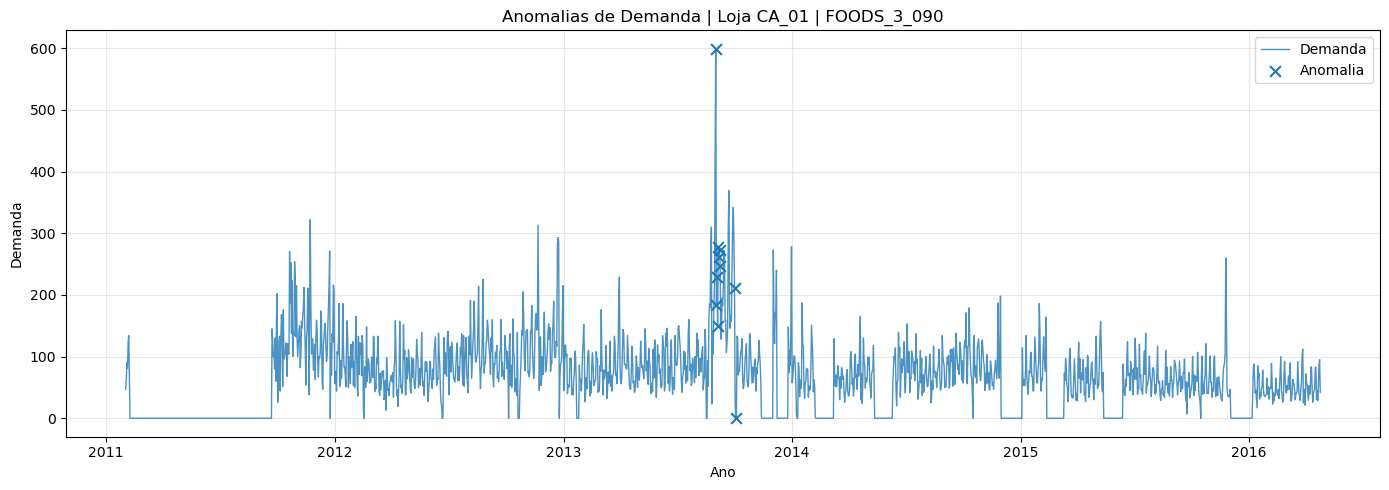

In [84]:
plot_item_anomalies(
    movimentacaoLojaCA_1,
    item_id='FOODS_3_090'
)

In [67]:
movimentacaoLojaCA_1[(movimentacaoLojaCA_1['sell_price']>=1.0) & (movimentacaoLojaCA_1['item_id']=='FOODS_3_090')]

,id,item_id,dept_id,cat_id,store_id,state_id,day,value,date,wm_yr_wk,...,sell_price,lag_1,lag_2,lag_3,rolling_mean_7,rolling_mean_14,rolling_std_7,rolling_std_14,anomaly_score,anomaly
1340820,FOODS_3_090_CA_1_validation,FOODS_3_090,FOODS_3,FOODS,CA_1,CA,4,47,2011-02-01,11101,...,1.25,47.0,182.0,107.0,112.000000,112.000000,67.638746,67.638746,0.121870,1
1340821,FOODS_3_090_CA_1_validation,FOODS_3_090,FOODS_3,FOODS,CA_1,CA,5,62,2011-02-02,11101,...,1.25,47.0,47.0,182.0,95.750000,95.750000,64.080028,64.080028,0.125911,1
1340822,FOODS_3_090_CA_1_validation,FOODS_3_090,FOODS_3,FOODS,CA_1,CA,6,90,2011-02-03,11101,...,1.25,62.0,47.0,47.0,89.000000,89.000000,57.510869,57.510869,0.157470,1
1340823,FOODS_3_090_CA_1_validation,FOODS_3_090,FOODS_3,FOODS,CA_1,CA,7,81,2011-02-04,11101,...,1.25,90.0,62.0,47.0,89.166667,89.166667,51.440905,51.440905,0.154213,1
1340824,FOODS_3_090_CA_1_validation,FOODS_3_090,FOODS_3,FOODS,CA_1,CA,8,124,2011-02-05,11102,...,1.25,81.0,90.0,62.0,88.000000,88.000000,47.060245,47.060245,0.158546,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1342725,FOODS_3_090_CA_1_validation,FOODS_3_090,FOODS_3,FOODS,CA_1,CA,1909,29,2016-04-20,11612,...,1.60,45.0,30.0,83.0,53.142857,53.285714,20.796062,20.503015,0.183003,1
1342726,FOODS_3_090_CA_1_validation,FOODS_3_090,FOODS_3,FOODS,CA_1,CA,1910,53,2016-04-21,11612,...,1.60,29.0,45.0,30.0,51.428571,51.571429,22.396854,21.507474,0.187888,1
1342727,FOODS_3_090_CA_1_validation,FOODS_3_090,FOODS_3,FOODS,CA_1,CA,1911,87,2016-04-22,11612,...,1.60,53.0,29.0,45.0,52.714286,52.571429,22.156371,21.201285,0.173468,1
1342728,FOODS_3_090_CA_1_validation,FOODS_3_090,FOODS_3,FOODS,CA_1,CA,1912,95,2016-04-23,11613,...,1.60,87.0,53.0,29.0,58.428571,55.785714,25.363078,22.824341,0.172385,1
